<a href="https://www.kaggle.com/code/zammie/fruit?scriptVersionId=119809207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Classification of Fruits Using Deep Learning**

#### We trained our model on the classification of about 16,000 fruits. In the end, we served the model with an unseen data of about 5,000 fruits. By visual inspection, the model  classified all the images images of a batch correctly (a batch has 32 images). 

#### Our dataset is the Fruit Classification Dataset from Kaggle. We made use of the deep learning model by employing CNN.

### We Import the Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imghdr
import random
import gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

### We Introduce the Filepaths

In [3]:
train_dir = '/kaggle/input/fruit-recognition/train/train'
test_dir = '/kaggle/input/fruit-recognition/test/test'
filepath = 'my_model.h5'

batch_size = 32

### EDA 

In [4]:
categories = []
labels = []
images = []

for image_class in os.listdir(train_dir):
    categories.append(image_class)
    label = categories.index(image_class)
    for image in os.listdir(os.path.join(train_dir, image_class)):
        img_path = os.path.join(train_dir, image_class, image)
        labels.append(label)
        
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (100, 100))
        img = np.array(img) 
        images.append(img)

In [5]:
images = np.array(images)
images.shape

(16854, 100, 100, 3)

In [6]:
images[0].max(), images[0].min()

(255, 0)

In [7]:
print('categories: ', len(categories))
print('labels: ', len(labels))
print('images: ', len(images))

categories:  33
labels:  16854
images:  16854


In [8]:
print(labels[:20])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
labels = np.array(labels)

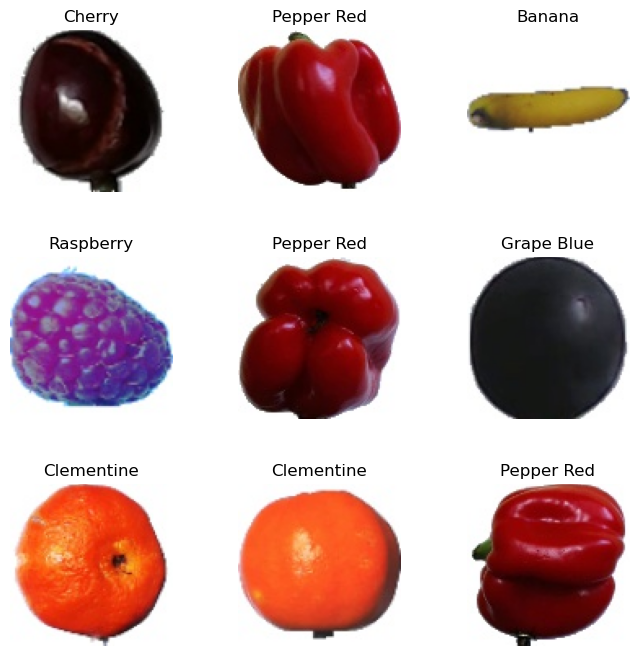

In [10]:
# We display 9 random images from the images dataset

random_indices = random.sample(range(len(images)),9)

fig, axs = plt.subplots(3,3, figsize=(8,8))
    
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[random_indices[i]])
    ax.set_axis_off()
    ax.set_title(categories[labels[random_indices[i]]])
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)  
plt.show()

### Splitting the Dataset

In [11]:
# We split the image dataset into train and validation dataset

train_data, valid_data, train_labels, valid_labels = train_test_split(
    images, labels, test_size=0.2, random_state=0, stratify=labels
)

### Image Preprocessing

In [12]:
train_datagen = ImageDataGenerator(
    zca_whitening=True, 
    rotation_range=20, 
    width_shift_range=0.2,  
    brightness_range=(0.3, 0.7), 
    shear_range=25, 
    zoom_range=0.7, 
    horizontal_flip=True, 
    rescale=1/255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1/255)

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1285: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [13]:
train_gen = train_datagen.flow(
    train_data, 
    train_labels,
    batch_size=batch_size,
    shuffle=True
)

valid_gen = train_datagen.flow(
    valid_data, 
    valid_labels,
    batch_size=batch_size,
    shuffle=True, 
)

In [14]:
del(images)

In [15]:
gc.collect()

177

### Importing the model

In [16]:
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, (2,2), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, (2,2), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, (2,2), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        8256      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                        

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
es = EarlyStopping(
    monitor ='val_accuracy', 
    patience=5, 
    mode='max', 
    restore_best_weights=True
)

tensorflow_callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')

checkpoint = ModelCheckpoint(filepath, save_weights_only=False, save_best_only=False)

### Training the Model on the Train and Validation Datasets

In [20]:
with tf.device('/device:GPU:0'):
    history = model.fit(
      train_gen, 
      steps_per_epoch=train_gen.n//batch_size,
      epochs=100, 
      callbacks=[es,tensorflow_callbacks,checkpoint], 
      validation_data=valid_gen, 
      validation_steps=valid_gen.n//batch_size, 
      batch_size=batch_size
    )

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
421/421 [==============================] - 63s 129ms/step - loss: 2.4043 - accuracy: 0.3337 - val_loss: 4.0883 - val_accuracy: 0.0756
Epoch 2/100
421/421 [==============================] - 53s 126ms/step - loss: 1.2037 - accuracy: 0.6216 - val_loss: 0.4580 - val_accuracy: 0.8836
Epoch 3/100
421/421 [==============================] - 53s 126ms/step - loss: 0.7671 - accuracy: 0.7588 - val_loss: 0.3141 - val_accuracy: 0.9027
Epoch 4/100
421/421 [==============================] - 64s 152ms/step - loss: 0.5788 - accuracy: 0.8193 - val_loss: 0.2023 - val_accuracy: 0.9360
Epoch 5/100
421/421 [==============================] - 53s 126ms/step - loss: 0.4410 - accuracy: 0.8585 - val_loss: 0.1337 - val_accuracy: 0.9634
Epoch 6/100
421/421 [==============================] - 53s 127ms/step - loss: 0.3527 - accuracy: 0.8897 - val_loss: 0.1013 - val_accuracy: 0.9732
Epoch 7/100
421/421 [==============================] - 63s 151ms/step - loss: 0.2943 - accuracy: 0.9054 - val_loss: 0.1000 -

### Learning from the Learning Curves

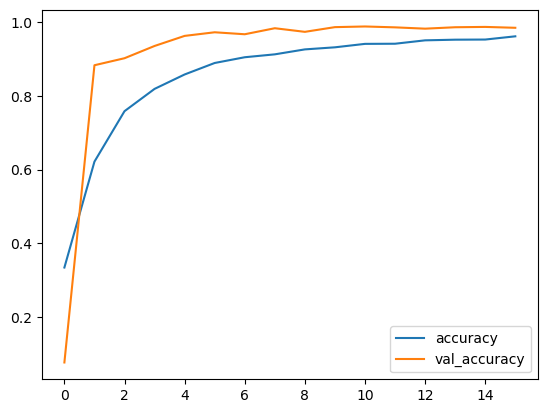

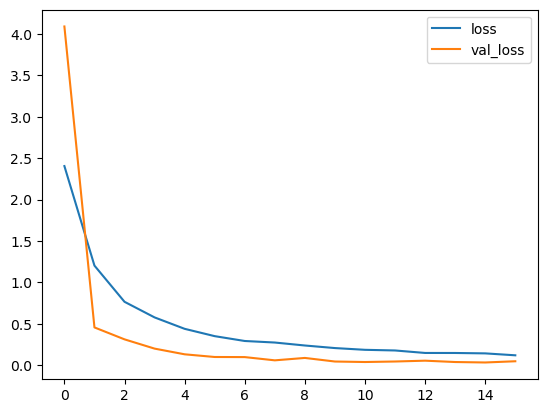

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()
history_df.loc[:,['loss','val_loss']].plot()
plt.show()

In [22]:
model.save(filepath)

### Preparing the Test Data

In [23]:
test_data = []

for image in os.listdir(test_dir):
    test_path = os.path.join(test_dir, image)
    img = cv.imread(test_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (100, 100))
    img = np.array(img)
    test_data.append(img)

In [24]:
test_data = np.array(test_data)
test_data.shape

(5641, 100, 100, 3)

In [25]:
test_gen = test_datagen.flow(test_data, batch_size=batch_size, shuffle=False)

In [26]:
model = load_model(filepath)

### Predictions

In [27]:
predictions = model.predict_generator(test_gen, steps = len(test_data)//32 +1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [28]:
len(test_data), len(test_gen)

(5641, 177)

In [29]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([ 0, 13,  9, ...,  1,  0,  4])

In [30]:
# The predicted names of the 5,641 fruits
predicted_class_names = [categories[idx] for idx in predicted_classes]

In [31]:
test_gen[0].shape, test_gen[0][0].shape

((32, 100, 100, 3), (100, 100, 3))

### Visual Inspection of the Predicted Labels

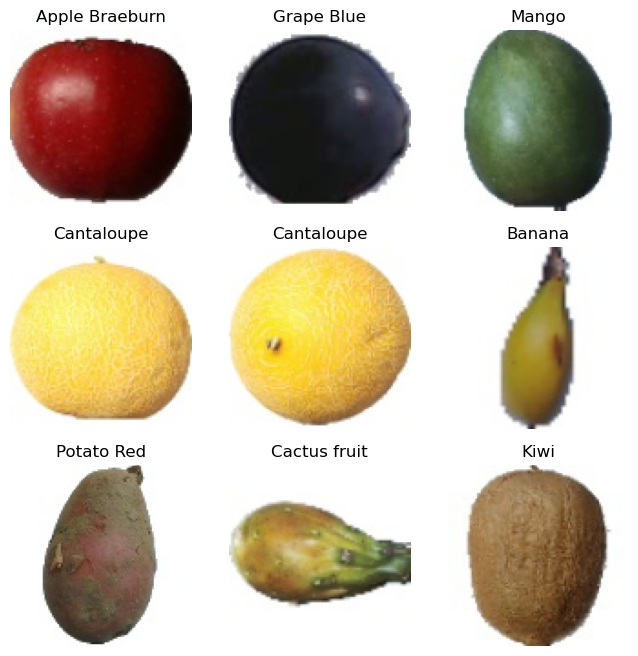

In [32]:
# We display 9 random images from the test data

num_images = len(test_gen)
random_indexes = np.random.choice(range(batch_size), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    idx = random_indexes[i]
    predicted_label = np.argmax(predictions[idx])
    img = test_gen[0][idx]
    ax.imshow(img)
    ax.set_title(categories[predicted_label])
    ax.axis('off')

plt.show()

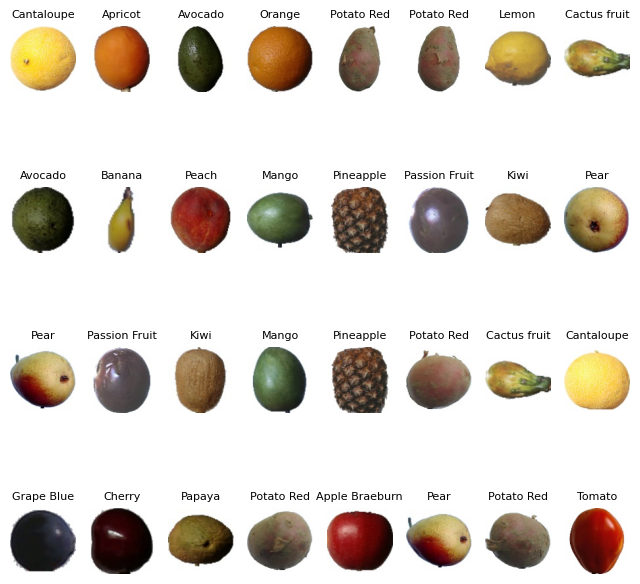

In [33]:
# We display all the images of a batch

num_images = len(test_gen)
random_indexes = np.random.choice(range(batch_size), size=batch_size, replace=False)

fig, axes = plt.subplots(4, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    idx = random_indexes[i]
    predicted_label = np.argmax(predictions[idx])
    img = test_gen[0][idx]
    ax.imshow(img)
    ax.set_title(categories[predicted_label], fontsize=8)
    ax.axis('off')

plt.show()